In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
import torch

# Stochastic autoencoder 2
This notebook implements part of the [eager model](https://docs.google.com/drawings/d/1czjcBtDQGS8X6bnIbYU4wmFvv1AfZt5wwSRk9oyQGw0/edit). Here we continue where we left off in [part 1](https://drive.google.com/open?id=1rlqZ2AX-ttlaa3rLSvr4zmN0Azj_Jf4m).

## Basics

In [0]:
import math
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
import numpy as np
import random
from scipy.ndimage.filters import gaussian_filter
from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: Use torch.normal(mean, std=1.0, out=None) 
class NormalDistributionTable(object):
    def __init__(self, resolution, var=0.07, table_resolution=100):
      self.resolution = resolution
      self.var = var
      self.table_resolution = table_resolution
      self.gaussians = torch.tensor([norm.pdf(np.arange(0, 1, 1.0 / self.resolution), mean, self.var) for mean in np.linspace(0, 1, self.table_resolution)])
      self.gaussians = self.gaussians.transpose(0, 1)
      self.gaussians = self.gaussians / self.gaussians.sum(dim=0)
      self.gaussians = self.gaussians.transpose(0, 1)

    def lookup(self, mean):
      assert mean >= 0 and mean <= 1, "mean must be between 0 and 1"
      index = math.floor(mean * self.table_resolution)
      if index == self.table_resolution:
        index = self.table_resolution - 1
      return self.gaussians[index]

    def to_pdf(self, images):
      element_count = np.prod(images.shape)
      images_shape = images.shape
      images_view = images.contiguous().view((element_count,))
      images_pdf = torch.stack([self.lookup(mean.item()) for mean in images_view])
      images_pdf = images_pdf.view(images_shape[:-1] + (images_shape[-1] * self.resolution, ))
      return images_pdf


def generate_images(width, height, count=100):
    images = []
    for _ in range(100):
        image = np.zeros((width, height))
        rr, cc, val = line_aa(random.randint(0, height-1), random.randint(0, width-1), random.randint(0, height-1), random.randint(0, width-1))
        image[rr, cc] = val
        image=gaussian_filter(image, 0.5)
        images.append(image)

    return torch.as_tensor(images).to(device)

def generate_moving_line(width, height, count=100):
  images = []
  for i in range(count):
    image = np.zeros((width, height))
    rr, cc, val = line_aa(2, 3-i, width-5, height-2-i)
    image[rr, cc] = val
    image=gaussian_filter(image, 0.5)
    images.append(image)

  return torch.as_tensor(images).to(device)


    
def show_image(image, vmin=None, vmax=None, title=None, print_values=False):
    #print("image ", image.shape)
    image = image.cpu().numpy()
    fig, ax1 = plt.subplots(figsize=(20, 8))
    if title:
        plt.title(title)
    #i = image.reshape((height, width))
    #print("i ", i.shape)
    ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
    plt.show()
    if print_values:
        print(image)
        
def sample_from_pdf1(pdf):
    assert pdf.shape == (resolution, )

    pk = pdf.copy()
    xk = np.arange(resolution)
    pk[pk<0] = 0
    sum_pk = sum(pk)
    if sum(pk) > 0:
        pk = pk / sum_pk
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        value = custm.rvs(size=1) / resolution
        # apply scale (conflates value and confidence!)
        value = value * sum_pk
        return value
    else:
        return [0]

def sample_from_pdf(pdf):
    assert pdf.shape == (resolution, )
    #print("pdf ", pdf)

    sum_pdf = sum(pdf)
    #print("sum_pdf ", sum_pdf)

    if sum_pdf > 0:
        v = random.random()
        #print("v ", v)

        s = 0
        index = 0
        while s < v and index < resolution:
          s += pdf[index] / sum_pdf
          index += 1
          #print("  s ", s)
          #print("  index ", index)
          
        # apply scale (conflates value and confidence!)
        return [(index - 1) * sum_pdf / resolution]
    else:
        return [0]


def sample_from_images__(images__):
    assert len(images__.shape) == 3

    # reshape images__ from (image count, height, width*resolution) into (image count*height*width, resolution)
    s = images__.shape
    flattened_images__ = images__.view(s[0], s[1], int(s[2] / resolution), resolution)
    s = flattened_images__.shape
    flattened_images__ = flattened_images__.view(s[0] * s[1] * s[2], s[3])

    # sample single value from each distributions into (image count*height*width, 1)
    sampled_pixels = torch.Tensor([sample_from_pdf(item.cpu().numpy()) for item in flattened_images__])

    # reshape back into (image count, height, width)
    sampled_images = sampled_pixels.view(s[0], s[1], s[2])

    return sampled_images


def averaged_sample_from_images__(images__, count=10):
    sampled_images = torch.stack([sample_from_images__(images__) for i in range(count)])
    return sampled_images.mean(dim=0)



## images to pdf and sample from pdf

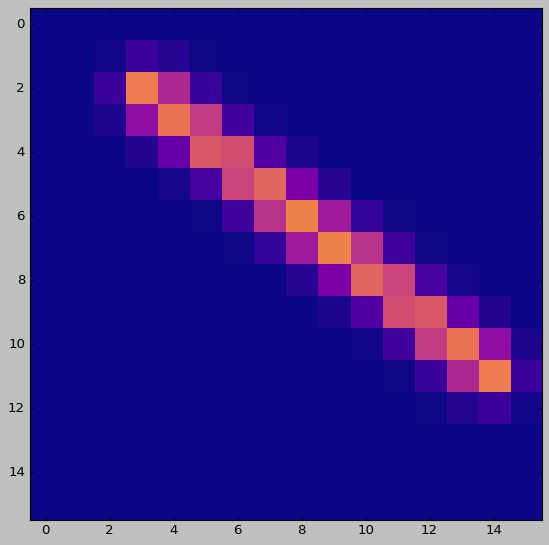

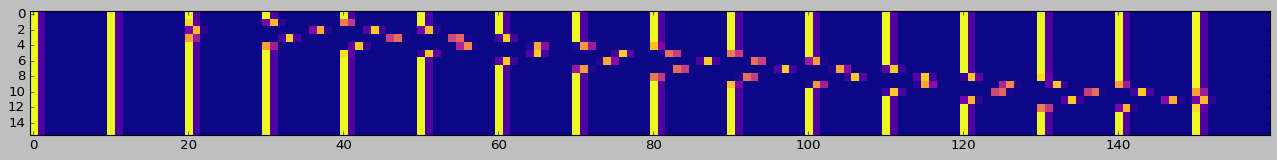

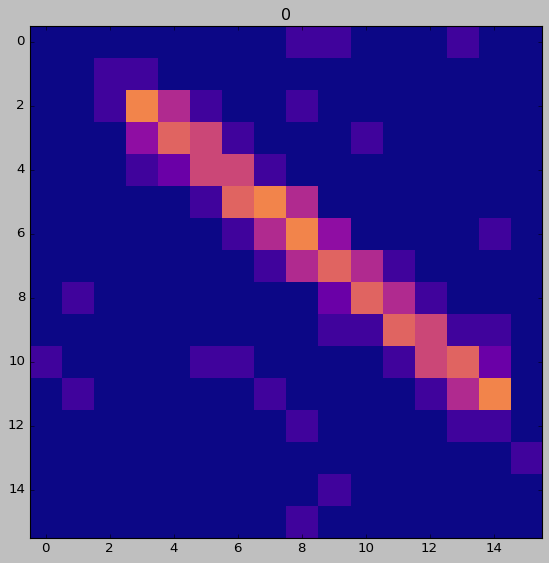

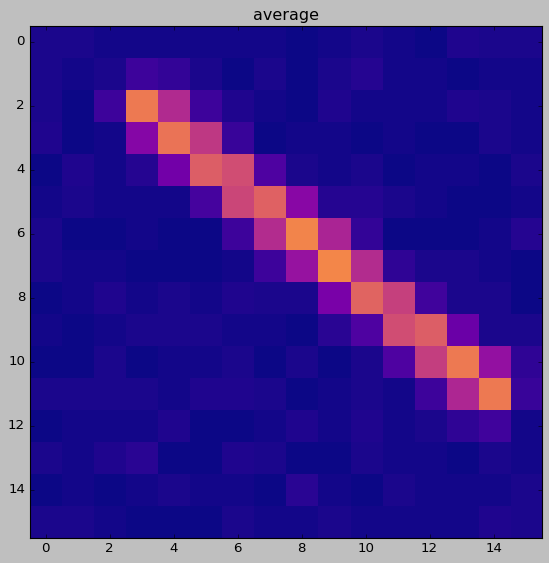

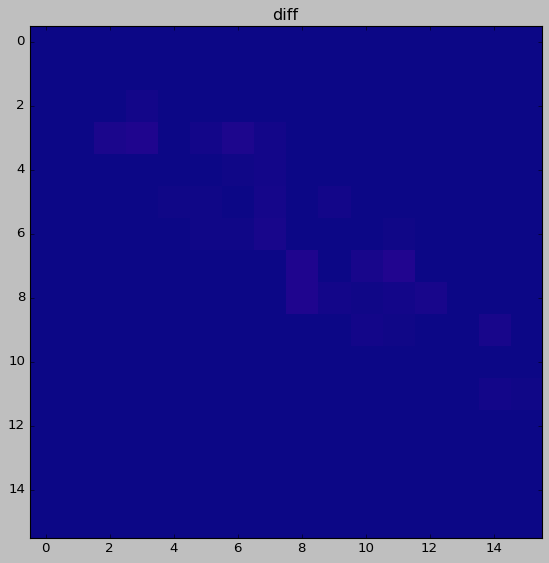

In [3]:
resolution = 10
var = 0.05
normal_distribution_table = NormalDistributionTable(resolution=resolution, var=var)
image_size = 16
#images = generate_images(image_size, image_size, count=2).float()
images = generate_moving_line(image_size, image_size, count=image_size).float()

show_image(images[0], vmin=0, vmax=1)
images__ = normal_distribution_table.to_pdf(images)
show_image(images__[0])
sampled_images = sample_from_images__(images__)

for i in range(1):  
  show_image(sampled_images[i], vmin=0, vmax=1, title=f"{i}")
  
sampled_images = averaged_sample_from_images__(images__, count=10)
show_image(sampled_images[0], vmin=0, vmax=1, title=f"average")

show_image(images[0] - sampled_images[0].to(device), vmin=0, vmax=1, title=f"diff")

## Autoencoder

In [0]:
class autoencoder(nn.Module):
    def __init__(self, a=3):
        super(autoencoder, self).__init__()
        self.a = a
        self.encoder = nn.Sequential(
            nn.Conv2d(1, a * a * 2, 3, stride=3, padding=1),  # b, 18, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 18, 5, 5
            nn.Conv2d(a * a * 2, a * a, 3, stride=2, padding=1),  # b, 9, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 9, 2, 2
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(a * a, 2 * a * a, 3, stride=2),  # b, 18, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(2 * a * a, a * a, 5, stride=3, padding=1),  # b, 9, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(a * a, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )
        self.encoder_output = None

    def forward(self, x):
        x = self.encoder_output = self.encoder(x)
        x = self.decoder(x)
        return x

### Moving line sequence

In [5]:
resolution = 10
var = 0.05
normal_distribution_table = NormalDistributionTable(resolution=resolution, var=var)
image_size = 16
image_count = image_size

images = generate_moving_line(image_size, image_size, count=image_count).float()
print("Distinct images in animation: ", images.shape)
mu1__ = normal_distribution_table.to_pdf(images)
print("mu1__: PDFs for images in animation: ", mu1__.shape)

#for i in range(30):
#  show_image(images[i], vmin=0, vmax=1, title=f"sample {i}")

Distinct images in animation:  torch.Size([16, 16, 16])
mu1__: PDFs for images in animation:  torch.Size([16, 16, 160])


### Train autoencoder

mu1__ --> samples_per_image samples per image = mu1 --> autoencoder --> mu1_bar

Duplicated PDFs for images in animation:  torch.Size([16, 16, 160])
mu1: Sampled images in animation:  torch.Size([400, 16, 16])
torch.Size([400, 1, 16, 16])
epoch [1/3000], loss:0.1721
epoch [301/3000], loss:0.0234
epoch [601/3000], loss:0.0229
epoch [901/3000], loss:0.0228
epoch [1201/3000], loss:0.0111
epoch [1501/3000], loss:0.0041
epoch [1801/3000], loss:0.0029
epoch [2101/3000], loss:0.0025
epoch [2401/3000], loss:0.0023
epoch [2701/3000], loss:0.0022


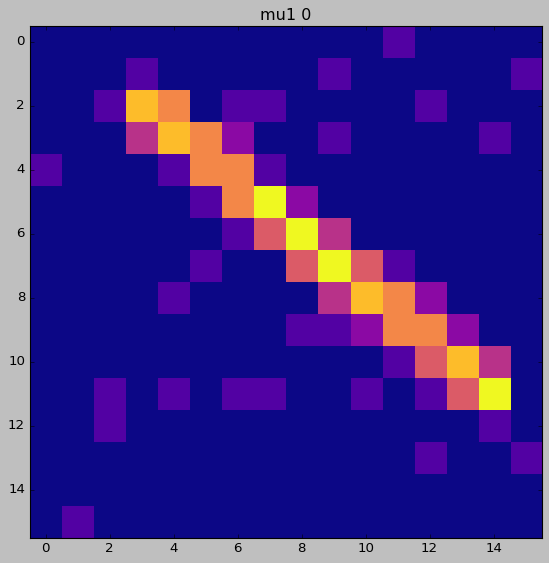

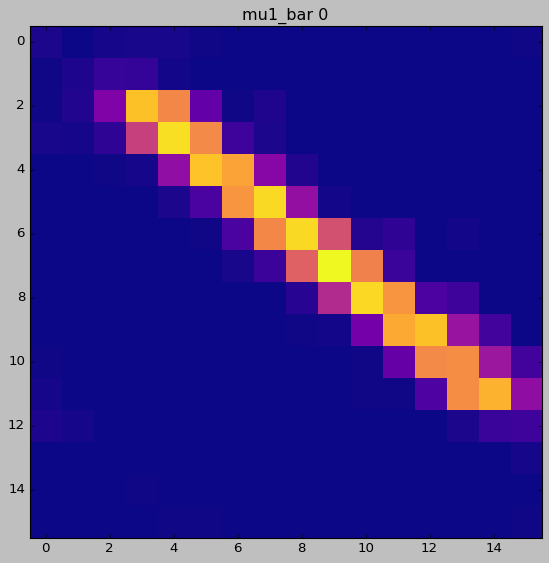

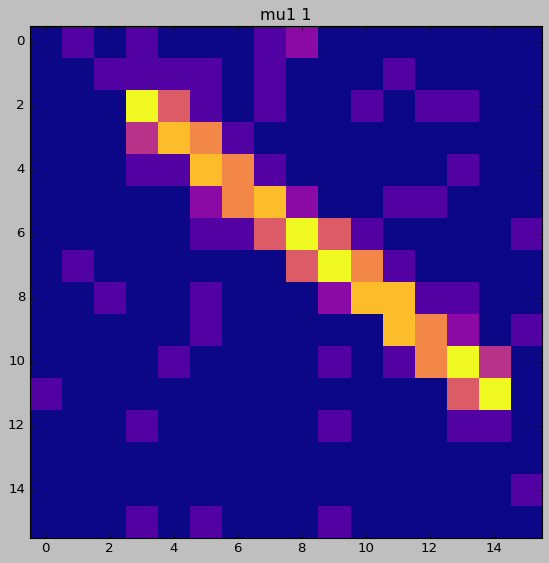

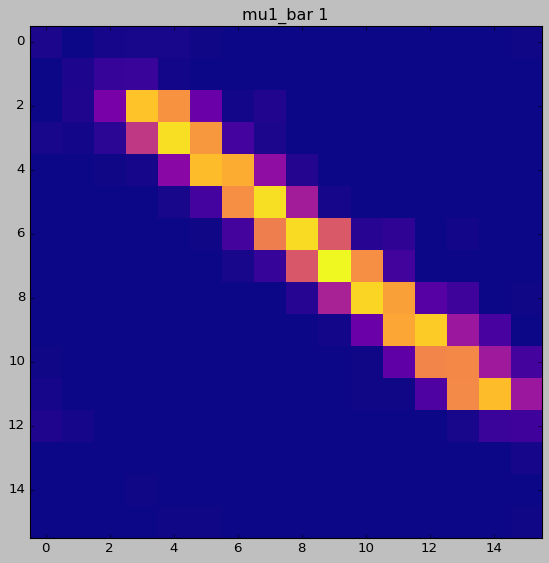

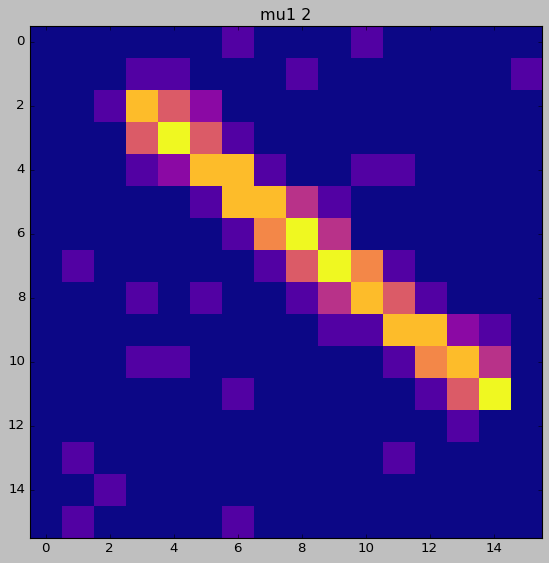

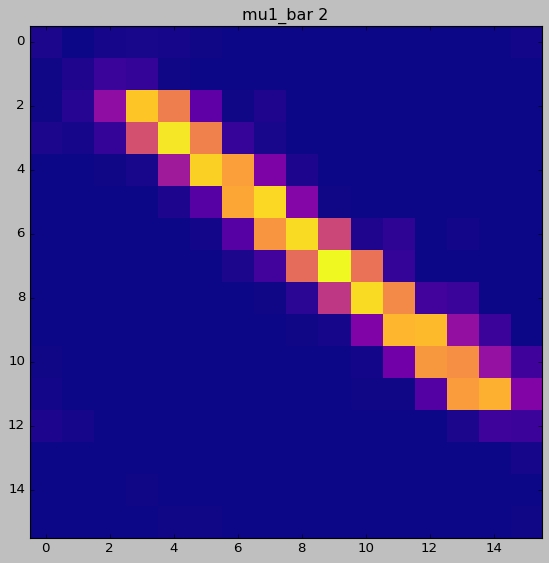

In [6]:
def train_autoencoder(model, mu1__, samples_per_image=10):
  learning_rate = 1e-3

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                               weight_decay=1e-5)

  mu1_duplicated__ = torch.stack([mu__.clone() for mu__ in mu1__ for _ in range(samples_per_image)])
  print("Duplicated PDFs for images in animation: ", mu1__.shape)
  mu1 = sample_from_images__(mu1_duplicated__)
  print("mu1: Sampled images in animation: ", mu1.shape)

  input = mu1[:, None, :, :].to(device)
  print(input.shape)

  num_epochs = 3000
  for epoch in range(num_epochs):
    output = model(input)
    loss = criterion(output, input)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % int(num_epochs / 10) == 0:
      print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch+1, num_epochs, loss.item()))

  return mu1, output[:,0,:,:]

samples_per_image = 25
model = autoencoder(a=3).to(device)
mu1, mu1_bar = train_autoencoder(model, mu1__, samples_per_image=samples_per_image)

for i in range(3):
  show_image(mu1[i], title=f"mu1 {i}")
  show_image(mu1_bar[i].detach(), title=f"mu1_bar {i}")


### Verify reconstructed pdf matches input pdf

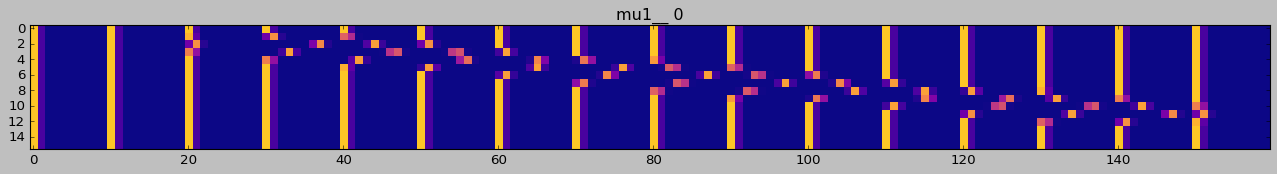

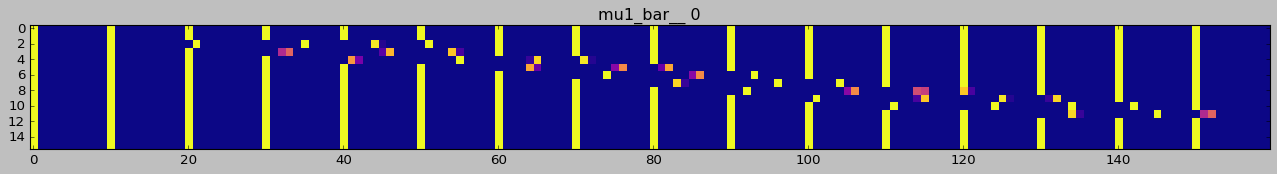

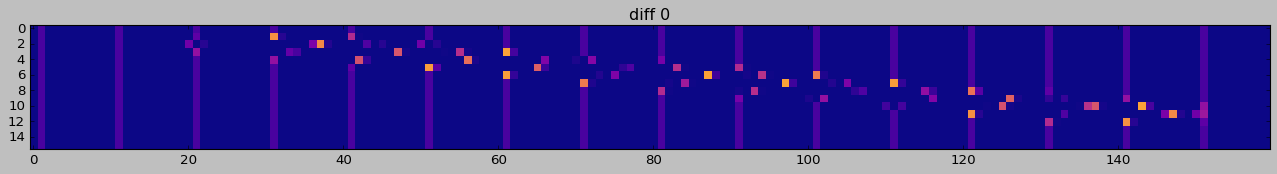

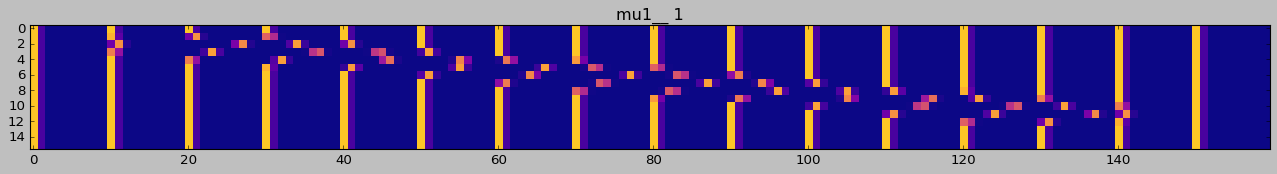

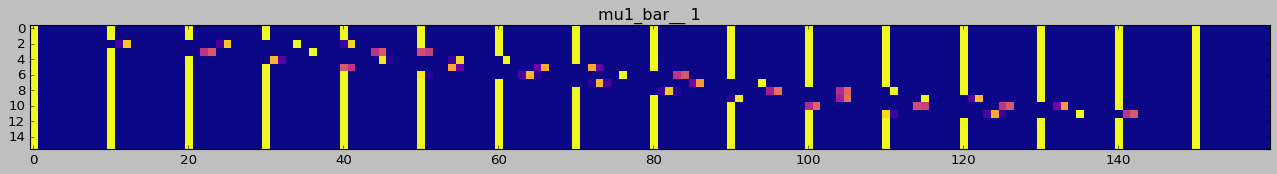

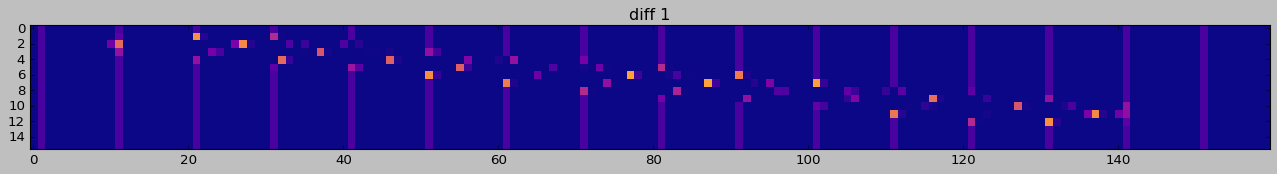

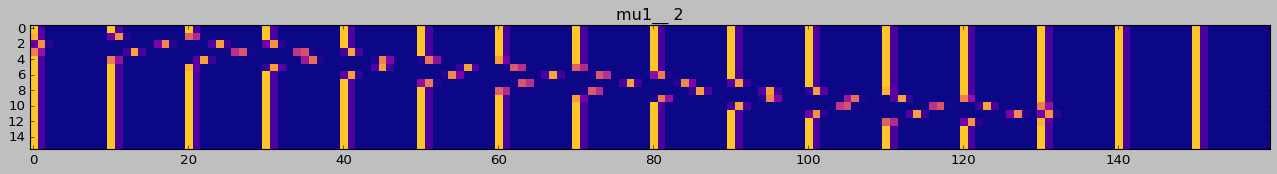

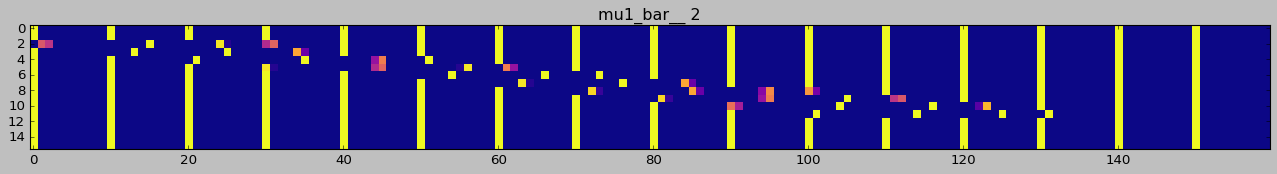

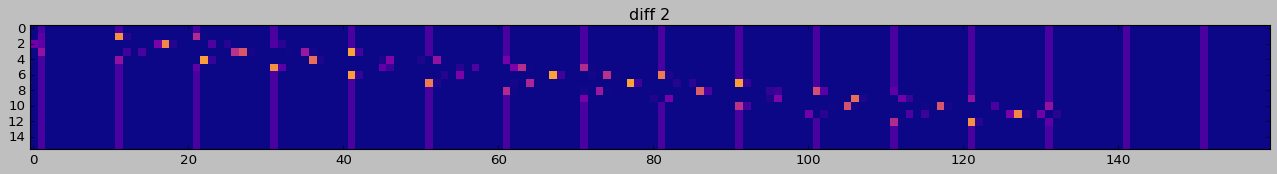

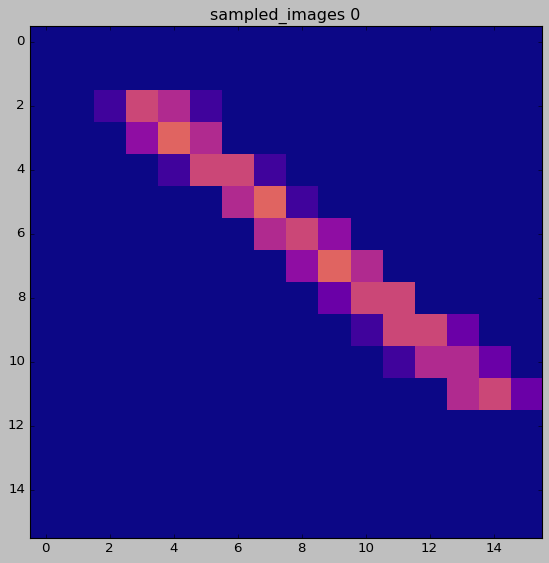

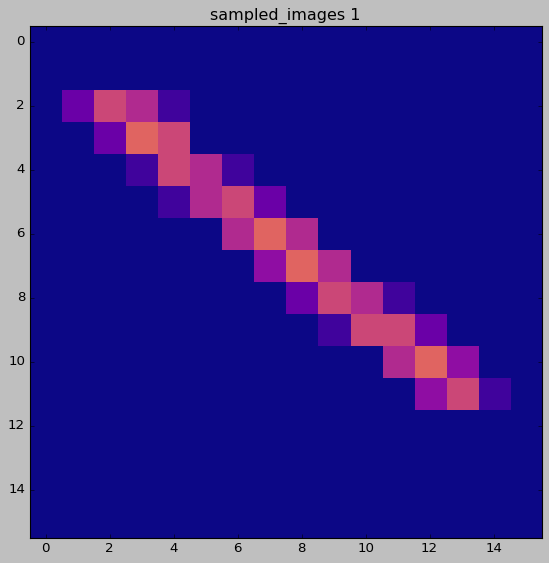

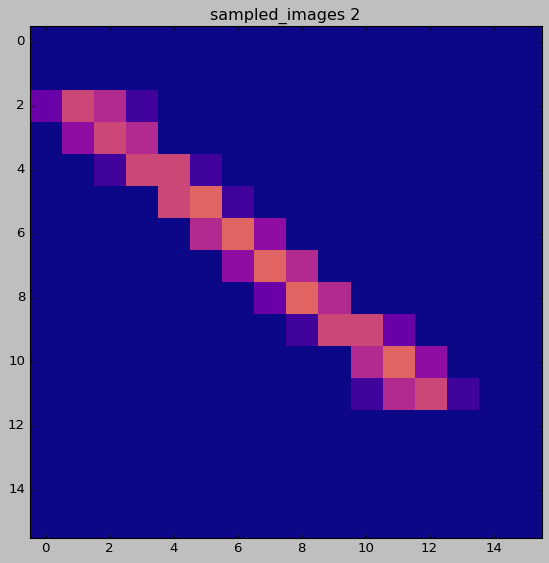

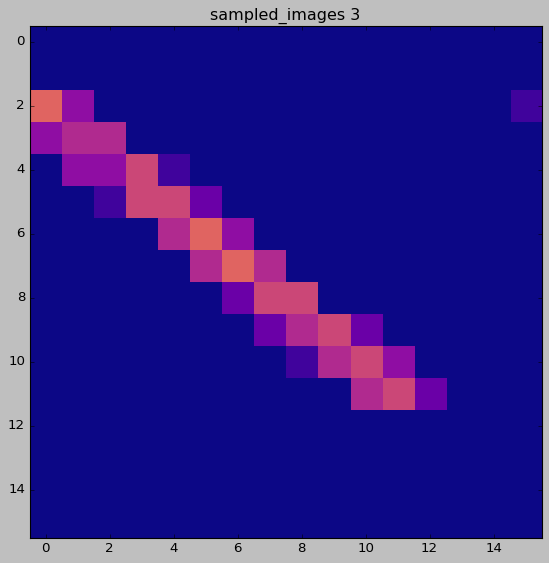

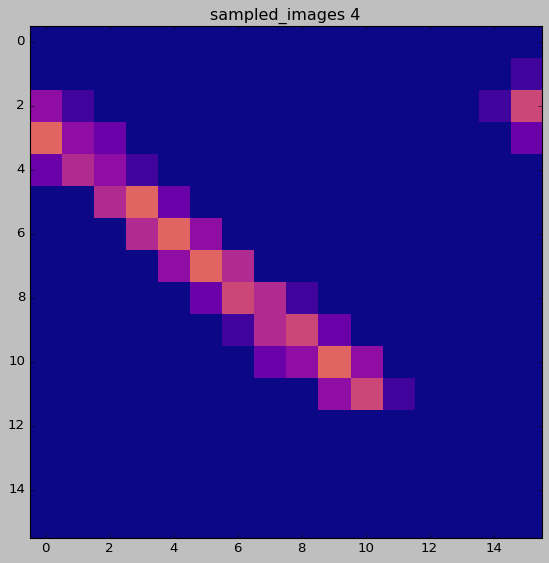

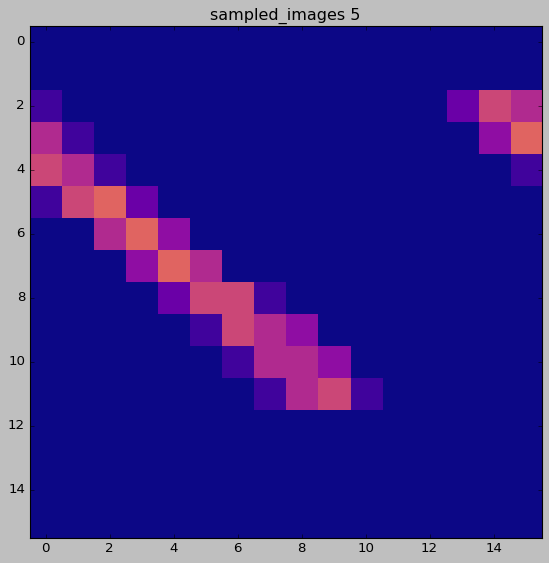

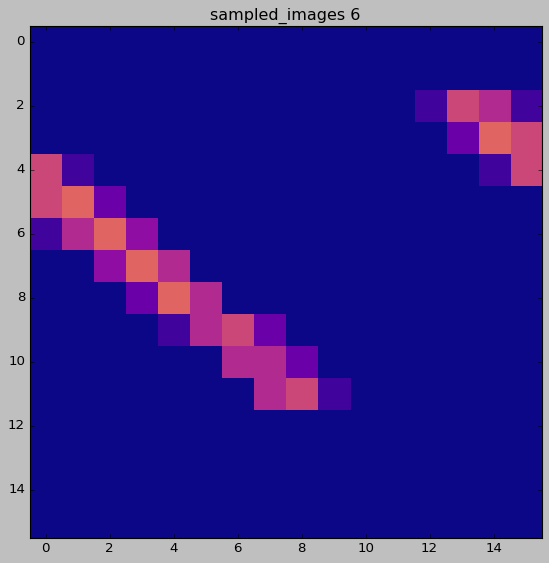

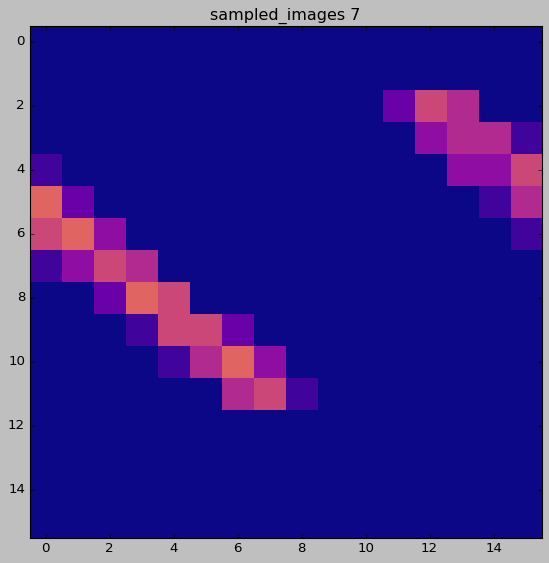

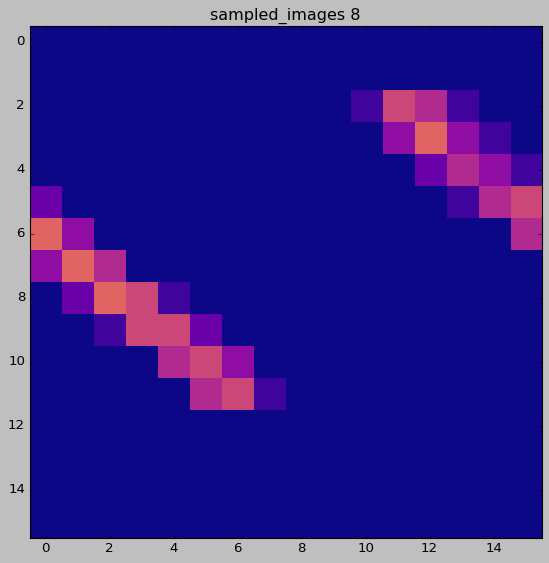

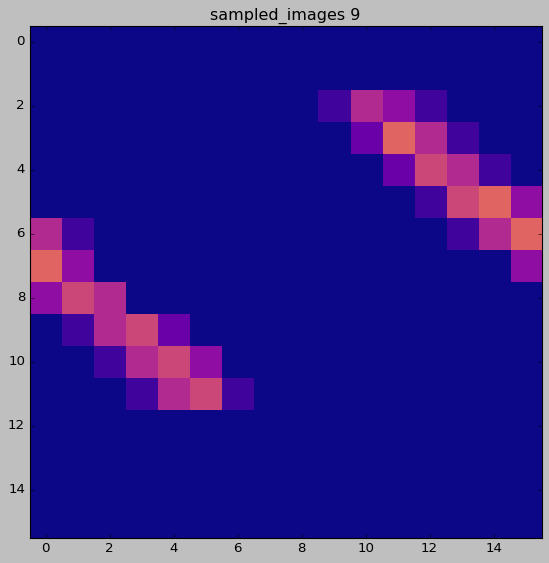

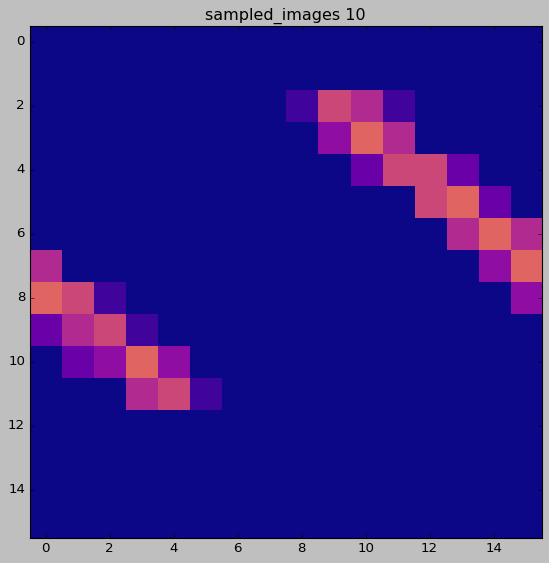

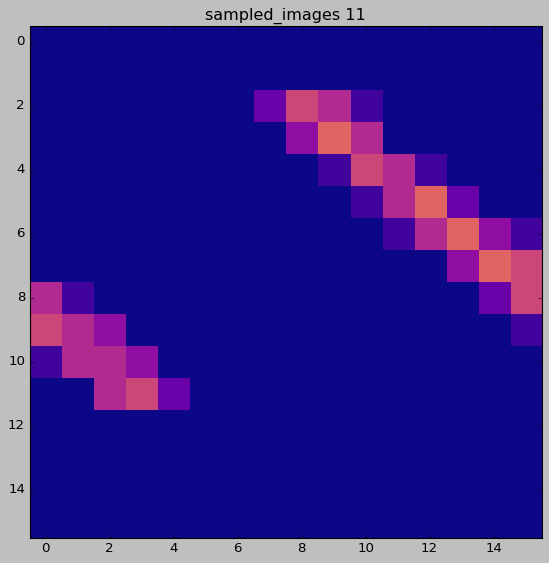

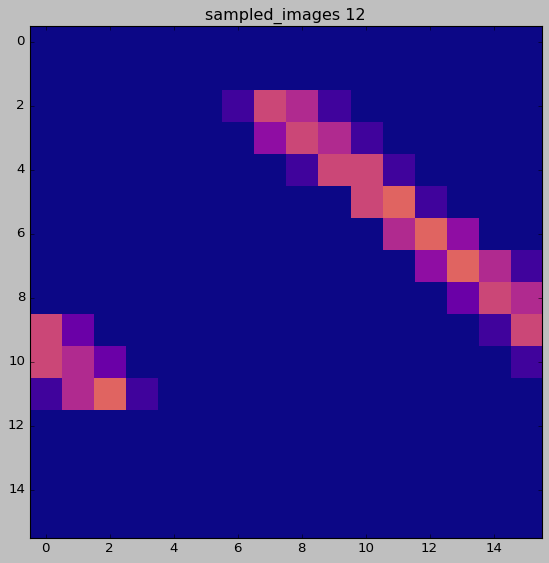

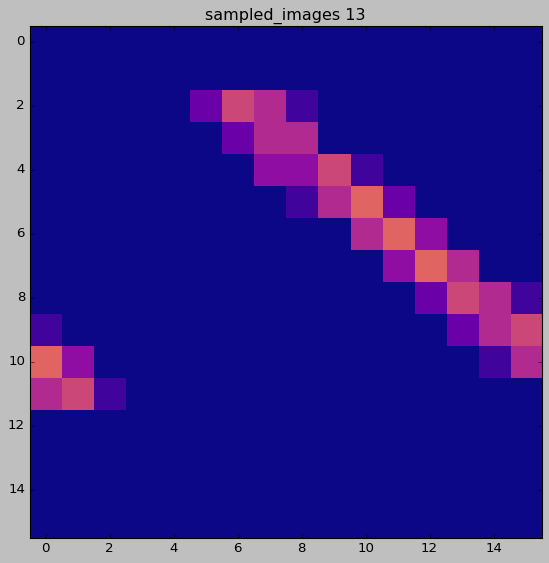

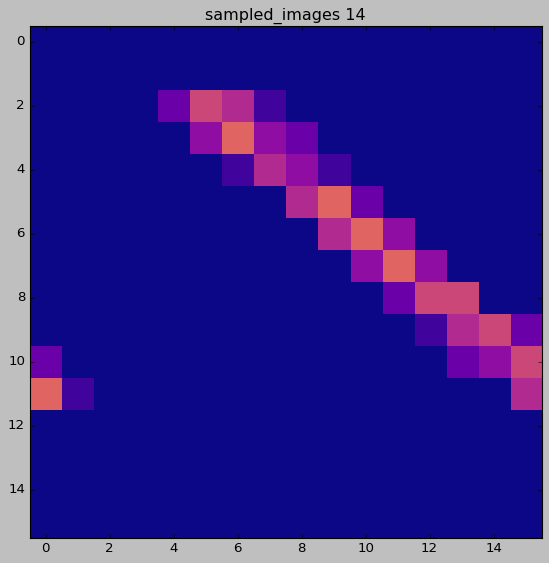

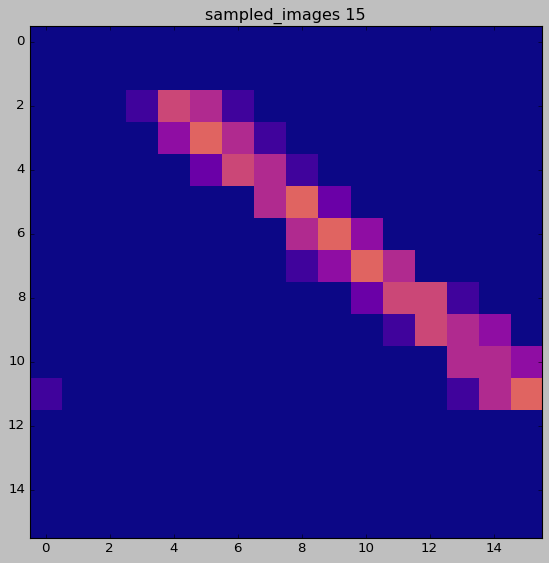

In [7]:
def aggregate_to_pdf(mu_bar, image_count, samples_per_image, iH, iW, resolution):
  # mu_bar                          (image_count * samples_per_image, iH, iW)
  # mu_bar_per_image                (image_count,  samples_per_image, iH, iW)
  mu_bar = mu_bar.clamp(0, 1)
  mu_bar_per_image = mu_bar.view(image_count, samples_per_image, iH, iW)

  # mu_bar_per_image_flattened      (image_count,  iH,  iW, samples_per_image)
  mu_bar_per_image_flattened = mu_bar_per_image.permute(0, 2, 3, 1).contiguous()
  # mu_bar_per_image_flattened      (image_count * iH * iW, samples_per_image)
  mu_bar_per_image_flattened = mu_bar_per_image_flattened.view(image_count * iH * iW, samples_per_image)


  # mu_bar_flattened__              (image_count * iH * iW, resolution)
  mu_bar_flattened__ = torch.zeros((image_count * iH * iW, resolution))
  assert mu_bar_per_image_flattened.shape[0] == mu_bar_flattened__.shape[0]

  for sample_index in range(samples_per_image):
    #print("mu_bar_per_image_flattened[:, sample_index] ", mu_bar_per_image_flattened[:, sample_index])
    histogram_indices = (mu_bar_per_image_flattened[:, sample_index] * resolution).long().cpu()
    for item_index in range(mu_bar_per_image_flattened.shape[0]): # TODO: Vectorize!
      mu_bar_flattened__[item_index][histogram_indices[item_index]] += 1

  # mu_bar__                        (image_count, iH, iW * resolution)
  mu_bar__ = mu_bar_flattened__.view((image_count, iH, iW,  resolution))
  mu_bar__ = torch.nn.functional.normalize(mu_bar__, p=1, dim=3)
  mu_bar__ = mu_bar__.view(          (image_count, iH, iW * resolution))

  return mu_bar__

mu1_bar__ = aggregate_to_pdf(mu_bar=mu1_bar, image_count=image_count, samples_per_image=samples_per_image, iH=image_size, iW=image_size, resolution=resolution)
assert mu1_bar__.shape == mu1__.shape

for i in range(3):
  show_image(mu1__[i], title=f"mu1__ {i}", vmin=0, vmax=1)
  show_image(mu1_bar__[i].detach(), title=f"mu1_bar__ {i}", vmin=0, vmax=1)
  show_image(mu1__[i] - mu1_bar__[i].detach().double(), title=f"diff {i}", vmin=0, vmax=1)


sampled_images = sample_from_images__(mu1_bar__)
for i in range(sampled_images.shape[0]):
  show_image(sampled_images[i].detach(), title=f"sampled_images {i}", vmin=0, vmax=1)

## Hidden to next layer

In [41]:
# Assume input (samples, feature maps, height, width) and that 
# features maps is a perfect squere, e.g. 9, of an integer 'a', e.g. 3 in this case
# Output (samples, height * a, width * a)
def flatten_feature_maps(f):
    s = f.shape
    f = f.permute(0, 2, 3, 1) # move features to the end
    s = f.shape
    a = int(s[3] ** 0.5)  # feature maps are at pos 3 now that we want to first split into a square of size (a X a)
    assert a * a == s[3], "Feature map count must be a perfect square"
    f = f.view(s[0], s[1], s[2], a, a)
    f = f.permute(0, 1, 3, 2, 4).contiguous() # frame count, height, sqr(features), width, sqr(features)
    s = f.shape
    f = f.view(s[0], s[1] * s[2], s[3] * s[4]) # each point becomes a square of features
    return f
  
# Assume input (samples, height * a, width * a)
# Output (samples, feature maps, height, width)
def unflatten_feature_maps(f, a):
    s = f.shape
    f = f.view(s[0], a, int(s[1] / a), a, int(s[2] / a))
    
    f = f.permute(0, 1, 3, 2, 4) # move features to the front
    s = f.shape
    f = f.view(s[0], a * a, s[3], s[4])
    return f

class EMA:
  def __init__(self, mu):
    super(EMA, self).__init__()
    self.mu = mu

  def forward(self,x, last_average):
    new_average = self.mu*x + (1-self.mu)*last_average
    return new_average

ema = EMA(0.9)
h1 = model.encoder_output
h1_flattened = flatten_feature_maps(model.encoder_output)
print("images        ", images.shape)
print("mu1__         ", mu1__.shape)
print("h1            ", h1.shape)
print("h1_flattened  ", h1_flattened.shape)

h1__ = normal_distribution_table.to_pdf(h1_flattened)

last_average = h1__[0].clone()
for index in range(1, h1__.shape[0]):
  h1__[index] = last_average = ema.forward(h1__[index], last_average)

#h1__ = h1__[range(0, h1__.shape[0], samples_per_image)]
print("h1__          ", h1__.shape)

images         torch.Size([16, 16, 16])
mu1__          torch.Size([16, 16, 160])
h1             torch.Size([400, 9, 1, 1])
h1_flattened   torch.Size([400, 3, 3])
h1__           torch.Size([400, 3, 30])


sampled_h1              torch.Size([16, 3, 3])
unflattened_sampled_h1  torch.Size([16, 9, 1, 1])
decoded_mu1             torch.Size([16, 16, 16])


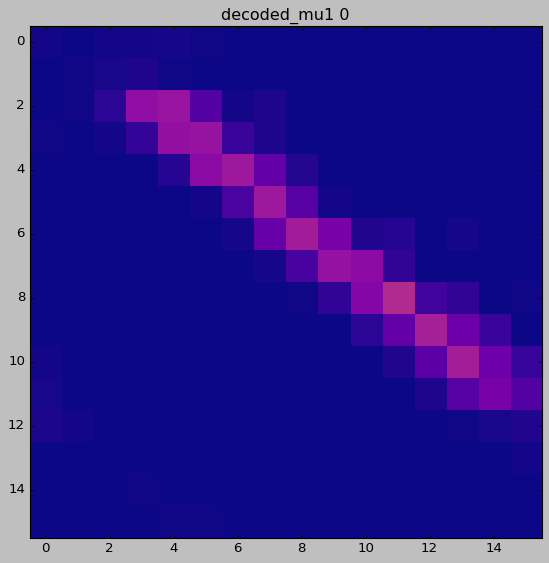

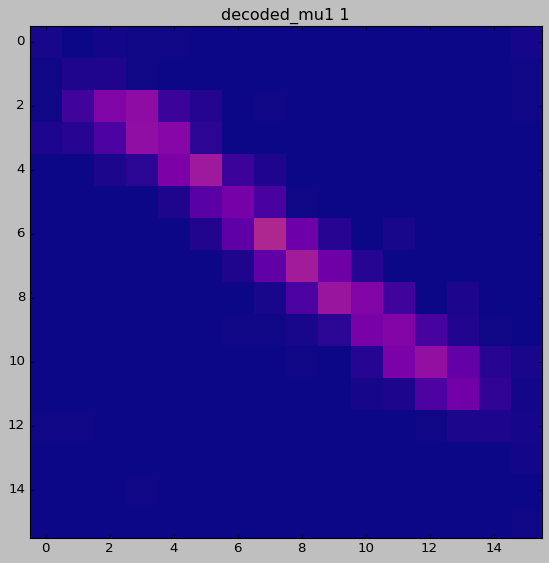

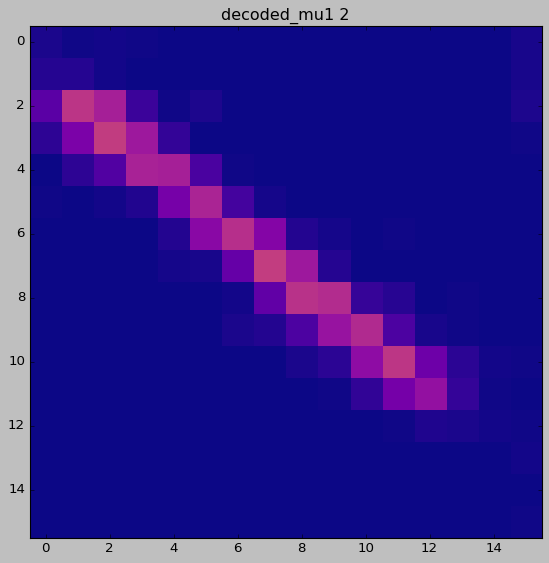

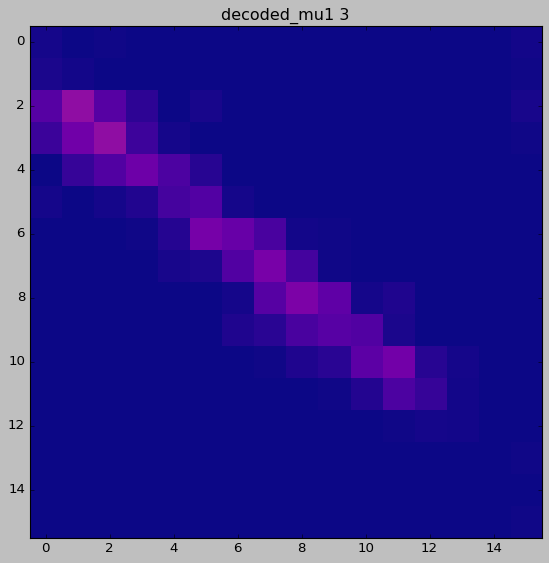

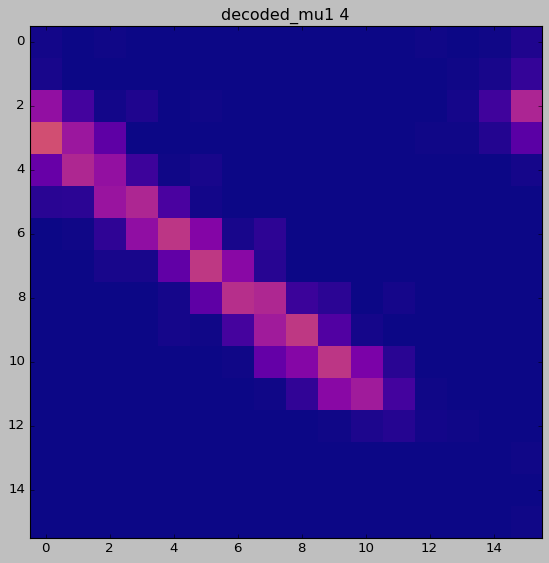

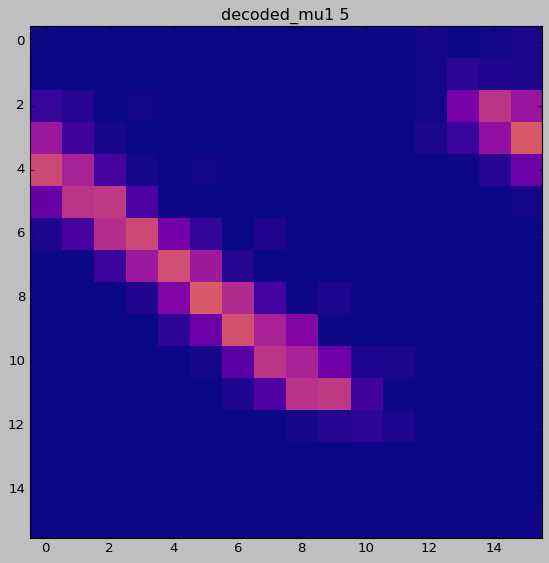

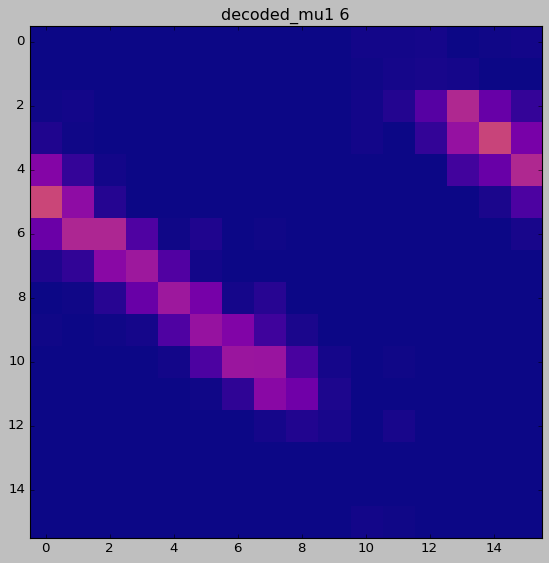

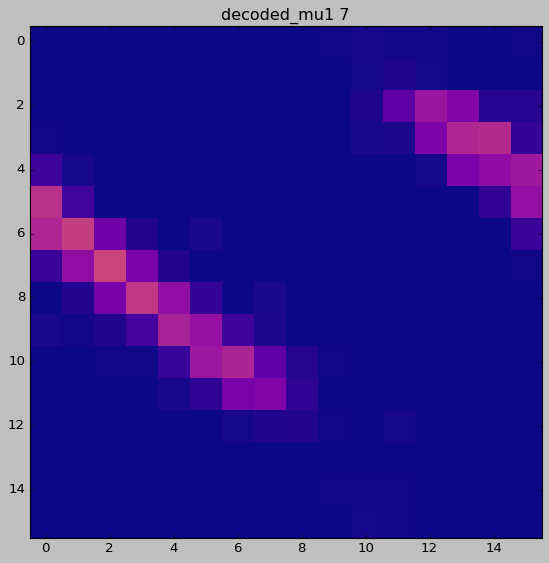

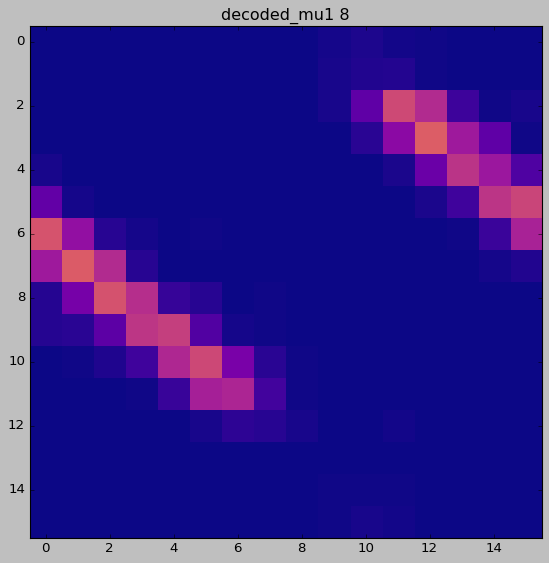

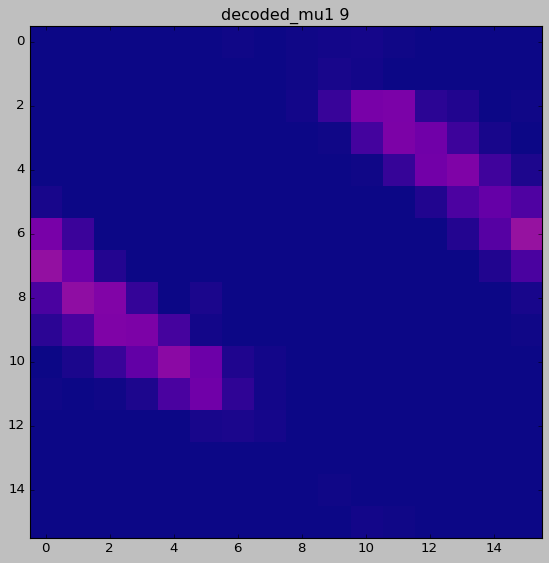

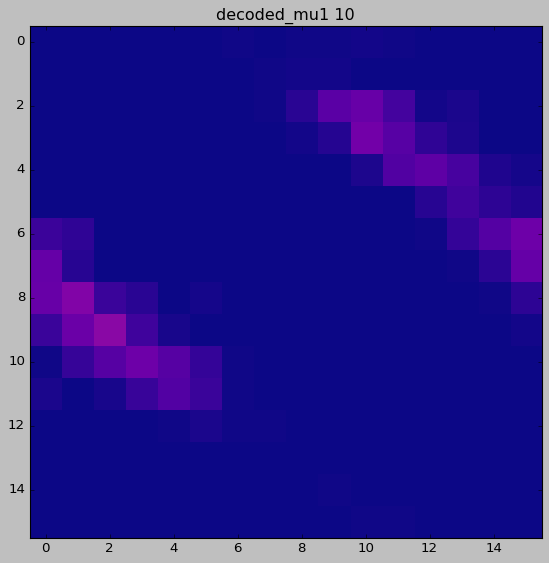

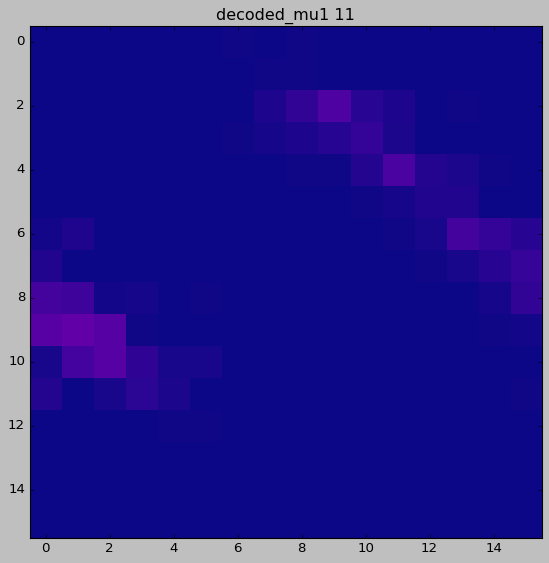

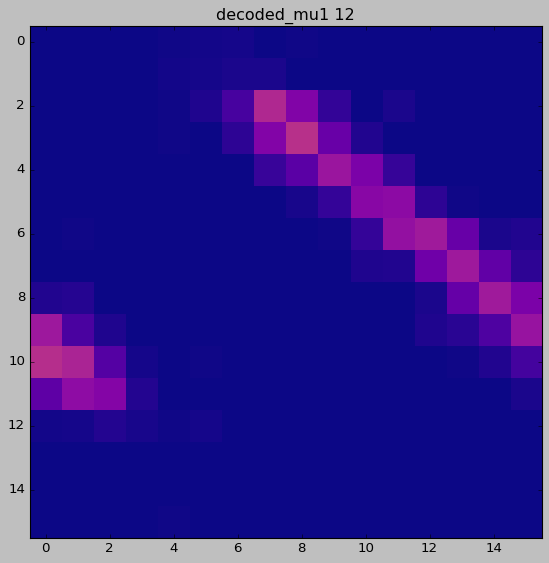

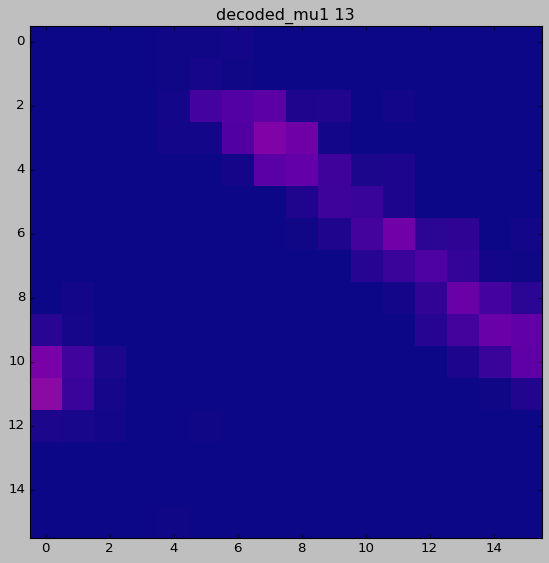

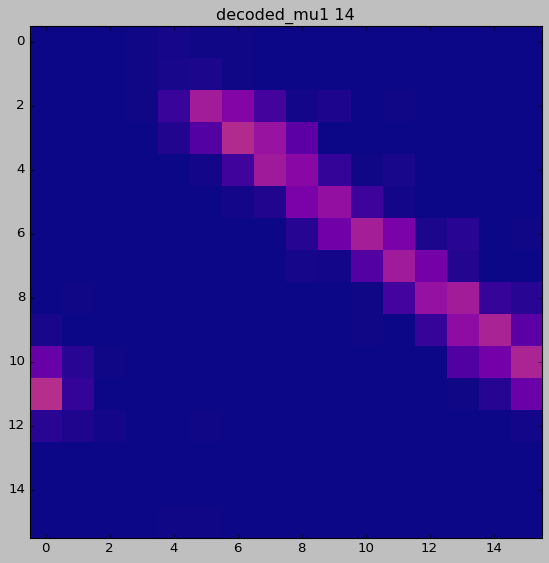

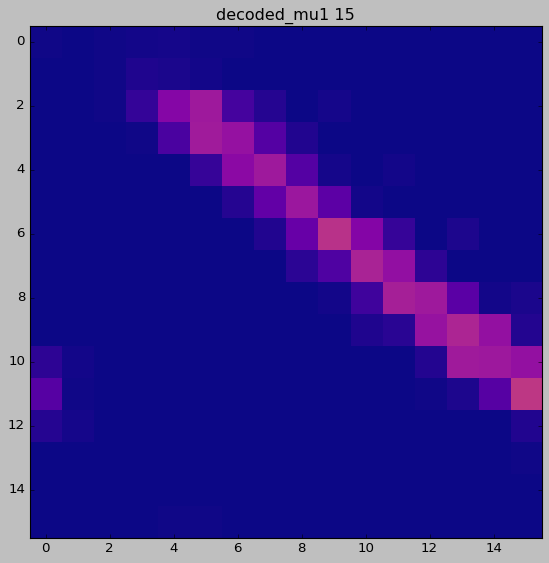

In [40]:
#for i in range(h1__.shape[0]):
#  show_image(h1__[i], title=f"h1__ {i}")

sampled_h1 = sample_from_images__(h1__)
print("sampled_h1             ", sampled_h1.shape)
unflattened_sampled_h1 = unflatten_feature_maps(sampled_h1, 3).to(device)
print("unflattened_sampled_h1 ", unflattened_sampled_h1.shape)

decoded_mu1 = model.decoder.forward(unflattened_sampled_h1)
decoded_mu1 = decoded_mu1[:, 0, :, :]
print("decoded_mu1            ", decoded_mu1.shape)

for i in range(decoded_mu1.shape[0]):
  show_image(decoded_mu1[i].detach(), title=f"decoded_mu1 {i}", vmin=0, vmax=1)
